In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [260]:
data=pd.read_csv("day.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [261]:
#Dropping columns :
#instant-not needed as index is not useful
#weekday,holiday - its already covered in working day so its a repetition
#dteday - already days,year and month is covered in other features
#casual,registered - since casual and registered cannot predict total count,they are just a biforcation of target variable
data.drop(["instant","dteday","casual","registered"],axis=1,inplace=True)

In [262]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [263]:
#Dummy encoding weathersit variable
#Combinations : 
#10 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#01 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#00 - Clear, Few clouds, Partly cloudy, Partly cloudy
# Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog -- Absent in data
weather_status=pd.get_dummies(data["weathersit"],drop_first=True)
weather_status.rename(columns={2:"misty",3:"light rain/snow"},inplace=True)
data=pd.concat([data,weather_status],axis=1)
data.drop("weathersit",axis=1,inplace=True)

In [264]:
#Dummy encoding seasons variable
#000-spring
#100-summer
#010-fall
#001-winter
seasons=pd.get_dummies(data["season"],drop_first=True)
seasons.rename(columns={2:"summer",3:"fall",4:"winter"},inplace=True)
data=pd.concat([data,seasons],axis=1)
data.drop("season",axis=1,inplace=True)

In [265]:
#Dataframe after encoding
data.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,misty,light rain/snow,summer,fall,winter
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0


In [266]:
#Describing numeric features in your dataset
numeric_features=["temp","atemp","hum","windspeed","cnt"]

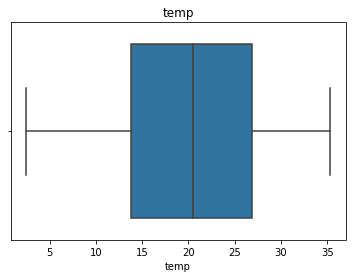

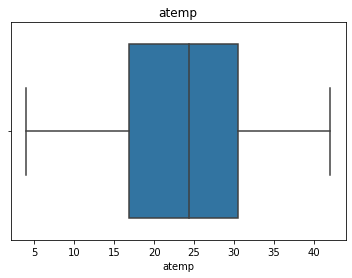

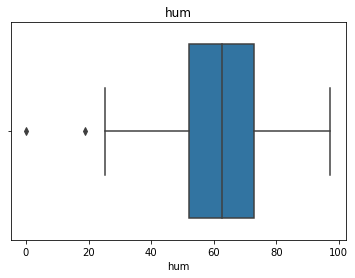

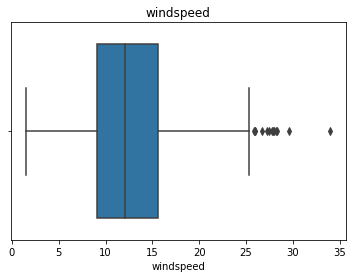

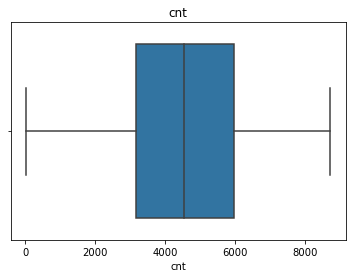

In [267]:
#Removing outliers from training data
#Checking box plot
for feature in numeric_features:
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.show()

In [268]:
#We can find some outliers in windspeed and humidity,capping those variables to maximum bounds
def cap_outliers(df,feature):
    q1=df[feature].describe()["25%"]
    q3=df[feature].describe()["75%"]
    iqr=q3-q1
    ub=q3+(1.5*iqr)
    lb=q1-(1.5*iqr)
    df.loc[df[feature] > ub, feature] = ub
    df.loc[df[feature] < lb, feature] = lb
    return df
    
data=cap_outliers(data,"windspeed")
data=cap_outliers(data,"hum")

In [269]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)

In [270]:
#Scaling Numeric features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#Training Set
df_train[numeric_features] = scaler.fit_transform(df_train[numeric_features])
#Test Set
df_test[numeric_features] = scaler.transform(df_test[numeric_features])

<AxesSubplot:>

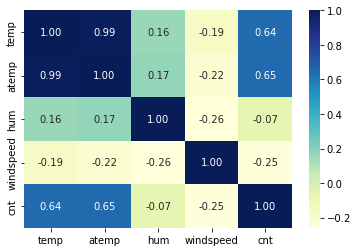

In [271]:
sns.heatmap(df_train[numeric_features].corr(),annot=True,cmap="YlGnBu",fmt=".2f")

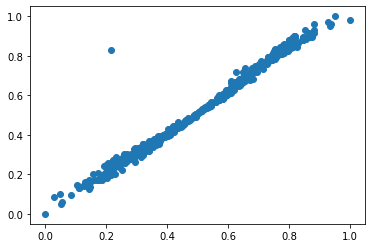

In [272]:
plt.scatter(x=df_train["atemp"],y=df_train["temp"])

In [273]:
#Dropping temp feature since its correlated with atemp very highly and follows a linear relation
#It will lead to multicolinearity in the model hence dropping it from data
#Actual temperature would be more relevant and has more correlation to target variable
df_train.drop("temp",axis=1,inplace=True)
df_test.drop("temp",axis=1,inplace=True)
data.drop("temp",axis=1,inplace=True)

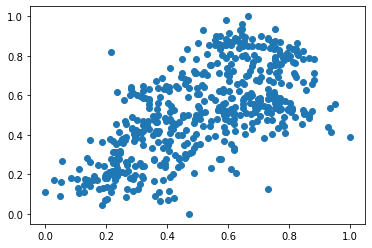

In [274]:
#Checking linearity of predictors with target variable
#actual temperature vs count
plt.scatter(x=df_train["atemp"],y=df_train["cnt"])
plt.show()

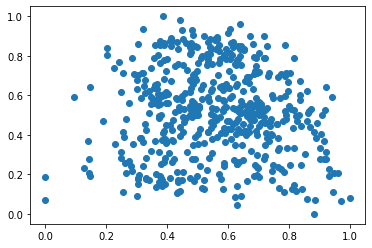

In [275]:
#Checking linearity of predictors with target variable
#humidity vs count
plt.scatter(x=df_train["hum"],y=df_train["cnt"])
plt.show()

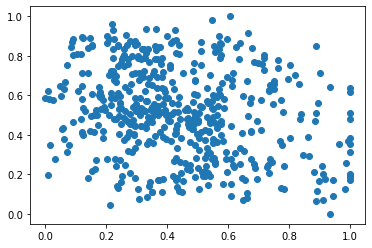

In [276]:
#Checking linearity of predictors with target variable
#windspeed vs count
plt.scatter(x=df_train["windspeed"],y=df_train["cnt"])
plt.show()

`All the numeric features show linearity with the target variable, it is good to use multi linear regression for this problem`


In [277]:
#Dividing into X & y sets
y_train = df_train.pop('cnt')
X_train = df_train

## Building Linear Model
### Following a bottoms up approach to keep adding on predictors, starting with atemp which seems the most correlated variable

#### **Feature 1** : `atemp`

In [278]:
import statsmodels.api as sm
feature_req=['atemp']
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()

In [279]:
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     364.7
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.10e-61
Time:                        00:36:47   Log-Likelihood:                 176.51
No. Observations:                 510   AIC:                            -349.0
Df Residuals:                     508   BIC:                            -340.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1629      0.020      8.199      0.000       0.124       0.202
atemp          0.6836      0.036     19.098      0.000       0.613       0.754
==============================================================================
Omnibus:                        3.316   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                2.842
Skew:                           0.090   Prob(JB):                        0.241
Kurtosis:                       2.682   Cond. No.                         6.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

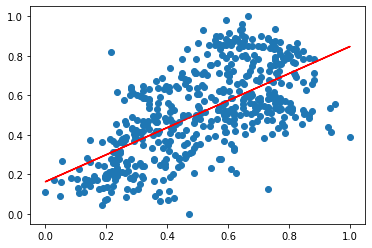

In [280]:
# Visualizing fitting potential of our model with actual data
x_train_atemp=X_train_sm.loc[:, "atemp"]
y_pred_atemp=lr.params["const"] + lr.params["atemp"]*X_train_sm.iloc[:, 1]
plt.scatter(x_train_atemp, y_train)
plt.plot(x_train_atemp,y_pred_atemp, 'r')
plt.show()

## Rsquared_1= `0.418`

#### **Feature 2** : `yr`
Since we can see the demand of bikes going up in 2019 as compared to 2018

In [281]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [282]:
feature_req.append('yr')
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()

In [283]:
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     579.5
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          1.07e-131
Time:                        00:36:48   Log-Likelihood:                 341.87
No. Observations:                 510   AIC:                            -677.7
Df Residuals:                     507   BIC:                            -665.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0721      0.015      4.810      0.000       0.043       0.102
atemp          0.6252      0.026     24.001      0.000       0.574       0.676
yr             0.2378      0.011     21.511      0.000       0.216       0.260
==============================================================================
Omnibus:                       38.030   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.520
Skew:                          -0.536   Prob(JB):                     1.96e-13
Kurtosis:                       4.266   Cond. No.                         6.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Rsquared_2 = `0.696`

#### **Feature 3** : `mnth`
Its logical that the month of the year can affect the demand, holiday seasons etc


In [284]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [285]:
feature_req.append('mnth')
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()

In [286]:
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     431.7
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          4.71e-139
Time:                        00:36:49   Log-Likelihood:                 362.28
No. Observations:                 510   AIC:                            -716.6
Df Residuals:                     506   BIC:                            -699.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.016      1.562      0.119      -0.006       0.057
atemp          0.5830      0.026     22.527      0.000       0.532       0.634
yr             0.2408      0.011     22.628      0.000       0.220       0.262
mnth           0.0102      0.002      6.494      0.000       0.007       0.013
==============================================================================
Omnibus:                       78.343   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.979
Skew:                          -0.840   Prob(JB):                     9.08e-37
Kurtosis:                       5.233   Cond. No.                         40.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Rsquared_3 = `0.719`

#### **Feature 4** : `misty,light rain/snow`
Weather can affect the demand for the bikes


In [287]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [288]:
feature_req.append('misty')
feature_req.append('light rain/snow')
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()

In [289]:
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     343.1
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          1.18e-159
Time:                        00:36:49   Log-Likelihood:                 416.54
No. Observations:                 510   AIC:                            -821.1
Df Residuals:                     504   BIC:                            -795.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0647      0.015      4.236      0.000       0.035       0.095
atemp               0.5567      0.023     23.732      0.000       0.511       0.603
yr                  0.2356      0.010     24.535      0.000       0.217       0.254
mnth                0.0115      0.001      8.045      0.000       0.009       0.014
misty              -0.0684      0.010     -6.732      0.000      -0.088      -0.048
light rain/snow    -0.2697      0.029     -9.424      0.000      -0.326      -0.213
==============================================================================
Omnibus:                       55.459   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.497
Skew:                          -0.654   Prob(JB):                     2.04e-23
Kurtosis:                       4.791   Cond. No.                         45.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Rsquared_4 = `0.773`

In [298]:
X_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'atemp', 'hum',
       'windspeed', 'misty', 'light rain/snow', 'summer', 'fall', 'winter'],
      dtype='object')

In [340]:
# feature_req=['atemp', 'yr', 'workingday','weekday','summer', 'fall', 'winter']
X_train_sm = sm.add_constant(X_train[feature_req])
lr = sm.OLS(y_train, X_train_sm).fit()
#Summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     217.1
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          2.08e-147
Time:                        00:49:16   Log-Likelihood:                 393.75
No. Observations:                 510   AIC:                            -771.5
Df Residuals:                     502   BIC:                            -737.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.019     -0.251      0.802      -0.042       0.032
atemp          0.5267      0.041     12.967      0.000       0.447       0.607
yr             0.2409      0.010     23.943      0.000       0.221       0.261
workingday     0.0191      0.011      1.787      0.075      -0.002       0.040
weekday        0.0079      0.002      3.184      0.002       0.003       0.013
summer         0.1123      0.018      6.167      0.000       0.077       0.148
fall           0.0931      0.024      3.954      0.000       0.047       0.139
winter         0.1496      0.015      9.658      0.000       0.119       0.180
==============================================================================
Omnibus:                      120.440   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.617
Skew:                          -1.103   Prob(JB):                     5.48e-81
Kurtosis:                       6.539   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [335]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
features=X_train[feature_req]
vif['Features'] = features.columns
vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

     Features    VIF
0       atemp  13.30
5        fall   5.45
4      summer   3.25
2  workingday   2.73
3     weekday   2.61
6      winter   2.36
1          yr   1.98
